In [ ]:
%pip install gurobipy
import numpy as np
from gurobipy import *
import matplotlib.pyplot as plt
import statistics
import numpy as np
import scipy.stats
from statistics import mean

     |████████████████████████████████| 11.5 MB 5.6 MB/s 


In [ ]:
# Creat first two initial dictionaries for generating test data
day_stats = {
    'Mon': 1, 
    'Tue': 2, 
    'Wed': 3, 
    'Thu': 4,
    'Fri': 5,
    'Sat': 6,
    'Sun': 7,
}

time_stats = {
    '8am': 1, 
    '10am': 2, 
    '12pm': 3, 
    '2pm': 4,
    '4pm': 5,
    '6pm': 6,
}
# Initialize the simulation with some number of candidates(workers)
init_num_candidates = 80
# init_num_times = 80

In [ ]:
# when find the least number that greater and equal than the number randomly generated based on norm distribution
# than will return the responding day immeditely and end the loop
# Subsequent functions follow the same logic
def generate_new_day(stats: dict = day_stats): 
  r = np.random.normal(3.5, 4)
  while r<0 or r>7:
    r = np.random.normal(3.5, 4)
    for bt in stats.keys():
      if stats[bt] >= r:
        return bt

In [ ]:
def generate_new_day(stats: dict = day_stats):
  r = np.random.normal(3.5, 4)
  while r<0 or r>7:
    r = np.random.normal(3.5, 4)
  for bt in stats.keys():
    if stats[bt] >= r:
      return(bt)
      break

In [ ]:
def generate_new_time_wek(stats: dict = time_stats):
  r = np.random.normal(3.5, 4)
  while r<0 or r>6:
    r = np.random.normal(3.5, 4)
  for bt in stats.keys():
    if stats[bt] >= r:
      return bt
      break

In [ ]:
def generate_new_time_wkn(stats: dict = time_stats):
  r = np.random.normal(3, 4)
  while r<0 or r>5:
    r = np.random.normal(3, 4)
  for bt in stats.keys():
    if stats[bt] >= r:
      return bt
      break

In [ ]:
r = np.random.normal(3.5, 3,1000)

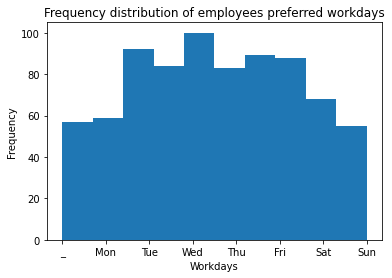

In [ ]:
# The distribution of data generated by the test

fig, ax = plt.subplots()
ax.hist(r,range=(0,7))
label_list=['_','Mon','Tue','Wed','Thu','Fri','Sat','Sun']
xx=range(len(label_list))
plt.xticks(xx,label_list,)
plt.xlabel('Workdays')
plt.ylabel('Frequency')
plt.title('Frequency distribution of employees preferred workdays')
plt.show()
#The area to the left of the scale 
#represents the number of samples for the corresponding scale.

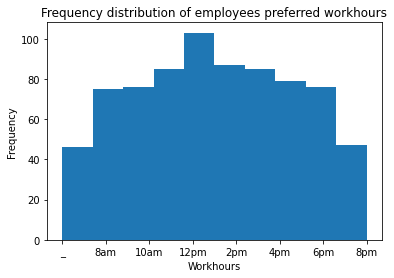

In [ ]:
fig, ax = plt.subplots()
ax.hist(r,range=(0,7))
label_list=['_','8am','10am','12pm','2pm','4pm','6pm','8pm']
xx=range(len(label_list))
plt.xticks(xx,label_list,)
plt.xlabel('Workhours')
plt.ylabel('Frequency')
plt.title('Frequency distribution of employees preferred workhours')
plt.show()
#The area to the left of the scale 
#represents the number of samples for the corresponding scale.

Model_1 greedy method with the multi-step iteration

In [ ]:
# initialize the data and creat several empty dicts to contain the data we need to fit in model
for i in range(10):
  C = {'Candidates '+str(key+1): generate_new_day(day_stats) for key in range(init_num_candidates)}
  D = {}
  temp={}
  data_of_cands={}
  for key in C.keys():
    data_of_cands[key]=[]
  # Generate preference list based on normal distribution

  for i in range(10):
    C = {'Candidates '+str(key+1): generate_new_day(day_stats) for key in range(init_num_candidates)}
    for key in C.keys():

      if C[key] == ['Sat','Sun']:
        D[key] = generate_new_time_wkn(time_stats)
      else:
        D[key] = generate_new_time_wek(time_stats)

      temp[key] = C[key]+'_'+D[key]
      # Avoid the same time on everyone's list
      while temp[key] in data_of_cands[key]:
        if C[key] == ['Sat','Sun']:
          D[key] = generate_new_time_wkn(time_stats)
        else:
          D[key] = generate_new_time_wek(time_stats)

        temp[key] = C[key]+'_'+D[key]
      data_of_cands[key].append(temp[key]) 

  # creat a dic that includes all avaliable options for candidates(workers)
  wek_time=['8am','10am','12pm','2pm','4pm','6pm']
  wkn_time=['8am','10am','12pm','2pm','4pm']
  day = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
  opt_times=[]
  for i in day:
    if i in ['Sat','Sun']:
      for j in wkn_time:
        opt_times.append(i+'_'+j)
    else:
      for j in wek_time:
        opt_times.append(i+'_'+j)
    
  # This step is just to facilitate the data access later
  options_of_times={key: opt_times[opt_times.index(key)] for key in opt_times}

  # Two status to count the # iterations

  candidates_status={}
  for key in C.keys():
    candidates_status[key]= 10
  times_status={}
  data_of_times={}
  for key in opt_times:
    times_status[key]= 5
    data_of_times[key]=[]

  # Setting weight for each candidates accroding to the status they are. Haven't done yet

  weight={}
  for key in C.keys():
    weight[key]= (11-candidates_status[key])*5
  # Interations
  # Each time just match one candidate with one option
  k=1
  for i in range(100):
    matches = mip(data_of_cands, options_of_times, candidates_status, times_status, weight)
    for m in matches:
      candidates_status[m[1]] -= 1
      times_status[m[0]] -= 1
      data_of_cands[m[1]].remove(m[0])
      data_of_times[m[0]].append(m[1])
      for key in C.keys():
        weight[key]= 11-candidates_status[key]
      if times_status[m[0]] < 1:
        options_of_times[m[0]] = None
    k=k+1
    if matches == []:
      break
    # Conclusion
  #not to cover the oringal data of times_status
  candidates_not_hire = candidates_status.copy()

  #del already satisfy time shift
  delete = []
  for key, val in candidates_not_hire.items():
      if val <10:
          delete.append(key)
          
  for i in delete:
      del candidates_not_hire[i]

  candidates_status_notstatisfy = candidates_status.copy()

  satisfy = []
  for key, val in candidates_status_notstatisfy.items():
      if val <=5 or val ==10 :
          satisfy.append(key)
          
  for i in satisfy:
      del candidates_status_notstatisfy[i]
      
  #Enter matching system but not fill the 10 hours per week percentage
  min_labor = len(data_of_cands)-len(candidates_not_hire)
  Percentage=(len(candidates_status_notstatisfy) / (min_labor))*100

  
  print('Mini_Labor# :',min_labor,'Unhired worker:',len(candidates_not_hire),'Percentage_%:',(round(Percentage,2)))

Mini_Labor# : 36 Unhired worker: 44 Percentage_%: 44.44
Mini_Labor# : 35 Unhired worker: 45 Percentage_%: 40.0
Mini_Labor# : 35 Unhired worker: 45 Percentage_%: 40.0
Mini_Labor# : 33 Unhired worker: 47 Percentage_%: 39.39
Mini_Labor# : 32 Unhired worker: 48 Percentage_%: 37.5
Mini_Labor# : 35 Unhired worker: 45 Percentage_%: 42.86
Mini_Labor# : 37 Unhired worker: 43 Percentage_%: 48.65
Mini_Labor# : 35 Unhired worker: 45 Percentage_%: 45.71
Mini_Labor# : 31 Unhired worker: 49 Percentage_%: 29.03
Mini_Labor# : 35 Unhired worker: 45 Percentage_%: 42.86


In [ ]:
#Mixed integer programming.
def mip(data_of_cands: dict, options_of_times: dict, candidates_status: dict, times_status: dict, weight: dict):

  candidates = data_of_cands.keys()

  times = options_of_times.keys()

  model = Model('working_schedule')

  x = model.addVars([(i,j) for i in times for j in candidates if options_of_times[i] in data_of_cands[j]], vtype=GRB.INTEGER, name ='x')
  
  c1 = model.addConstrs(quicksum(x[i,j] for j in candidates if options_of_times[i] in data_of_cands[j]) <= 1 for i in times)
  #Match a worker for each specific time

  c2 = model.addConstrs(quicksum(x[i,j] for i in times if options_of_times[i] in data_of_cands[j]) <= 10  for j in candidates)
  #Match a time for each Candidate(worker)

  #model.setObjective(quicksum(x[i,j] for i in times for j in candidates if options_of_times[i] in data_of_cands[j]),GRB.MAXIMIZE)
  model.setObjective(quicksum(x[i,j]*weight[j] for i in times for j in candidates if options_of_times[i] in data_of_cands[j]),GRB.MAXIMIZE)
  #Find the highest number of matches
  #least number of summation of all matches(haven't finished yet)
  model.params.outputflag = 0
  model.optimize()
  model.Params.LogToConsole = 0
  matches = []
  for v in model.getVars():
    if v.X > 0:
      c = [s.strip(" '") for s in v.varName.strip("x[]").split(',')]
      matches.append(c)

  return matches


In [ ]:
# How many workers they need for each time after loop matching 100 times
times_status

#not to cover the oringal data of times_status
times_status_1 =times_status.copy()

#del already satisfy time shift
delete = []
for key, val in times_status_1.items():
    if val == 0:
        delete.append(key)
         
for i in delete:
    del times_status_1[i]
     
# Modified Dictionary    
print (len(times_status_1))

0


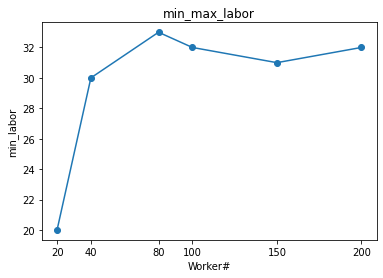

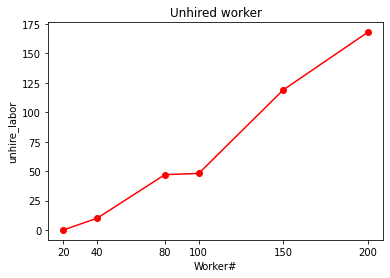

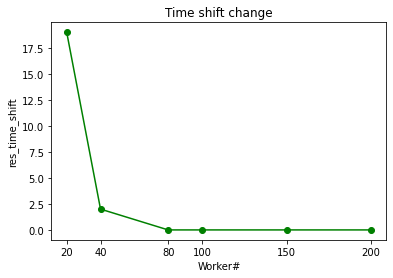

In [ ]:
#graph for model_1
# for worker =20 ,　min labor =20 , unhire =0, the rest of time shift=19
# for worker =40 ,　min labor =30 , unhire =10, the rest of time shift=2
# for worker =80 ,　min labor =33 , unhire =47, the rest of time shift=0 =>Max hire # worker
# for worker =100,　min labor =32 , unhire =48,　the rest of time shift= 
# for worker =150,　min labor =31 , unhire =119,　the rest of time shift=
# for worker =200,　min labor =32 , unhire =168,　the rest of time shift= 


pre10_Worker =[20,40,80,100,150,200]
pre10_min_labor =[20,30,33,32,31,32]
pre10_unhire =[0,10,47,48,119,168]
pre10_res_time =[19,2,0,0,0,0]
labels = [20,40,80,100,150,200]

#graph_1
plt.plot(pre10_Worker,pre10_min_labor,marker='o')
plt.xticks(pre10_Worker, labels)
plt.xlabel('Worker#')
plt.ylabel('min_labor')
plt.title("min_max_labor")
plt.show()


#graph_2
plt.plot(pre10_Worker,pre10_unhire,marker='o',color ='r')
plt.xticks(pre10_Worker, labels)
plt.xlabel('Worker#')
plt.ylabel('unhire_labor')
plt.title("Unhired worker")
plt.show()

#graph_3
plt.plot(pre10_Worker,pre10_res_time,marker='o',color ='g')
plt.xticks(pre10_Worker, labels)
plt.xlabel('Worker#')
plt.ylabel('res_time_shift')
plt.title("Time shift change")
plt.show()

Variable_Min labor# : 3.377777777777778
STD_Min labor# : 1.837873166945363
Average_Min labor# : 34.4


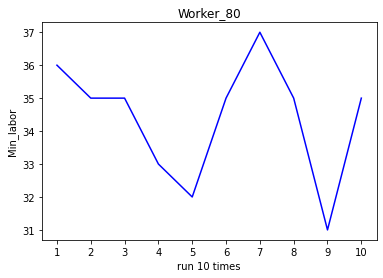

In [ ]:
#run 10times to caculate max value (Max hire labor is around 33 with worker=80)


number_80 =[1,2,3,4,5,6,7,8,9,10]
min_labor =[36,35,35,33,32,35,37,35,31,35]
mean_labor = mean(min_labor)


var = sum((item - mean_labor)**2 for item in min_labor) / (len(min_labor) - 1)
std = var ** 0.5
print('Variable_Min labor# :',var)
print('STD_Min labor# :',std)
print('Average_Min labor# :',mean_labor)


labels = [1,2,3,4,5,6,7,8,9,10]
plt.xticks(number_80, labels)
plt.plot(number_80,min_labor,color='blue')
plt.xlabel('run 10 times')
plt.ylabel('Min_labor')
plt.title("Worker_80")
plt.show()


Model _2 (One Step with mixed integer programming matching model)

In [ ]:
day = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
wek_time=['8am','10am','12pm','2pm','4pm','6pm']
wkn_time=['8am','10am','12pm','2pm','4pm']

In [ ]:
# creat a dic that includes all avaliable options for candidates(workers)
opt_times=[]
for i in day:
  if i in ['Sat','Sun']:
    for j in wkn_time:
      opt_times.append(i+'_'+j)
  else:
    for j in wek_time:
      opt_times.append(i+'_'+j)

In [ ]:
# This step is just to facilitate the data access later
options_of_times={key: opt_times[opt_times.index(key)] for key in opt_times}

In [ ]:
# initialize the data and creat several empty dicts to contain the data we need to fit in model
C = {'Candidates '+str(key+1): generate_new_day(day_stats) for key in range(init_num_candidates)}
D = {}
temp={}
data_of_cands={}
for key in C.keys():
  data_of_cands[key]=[]

In [ ]:
# Generate preference list based on normal distribution
for i in range(10):
  C = {'Candidates '+str(key+1): generate_new_day(day_stats) for key in range(init_num_candidates)}
  for key in C.keys():

    if C[key] == ['Sat','Sun']:
      D[key] = generate_new_time_wkn(time_stats)
    else:
      D[key] = generate_new_time_wek(time_stats)

    temp[key] = C[key]+'_'+D[key]
    # Avoid the same time on everyone's list
    while temp[key] in data_of_cands[key]:
      if C[key] == ['Sat','Sun']:
        D[key] = generate_new_time_wkn(time_stats)
      else:
        D[key] = generate_new_time_wek(time_stats)

      temp[key] = C[key]+'_'+D[key]
    data_of_cands[key].append(temp[key]) 

# data_of_cands 

In [ ]:
# Two status to count the

candidates_status={}
for key in C.keys():
  candidates_status[key]= 10
times_status={}
data_of_times={}
for key in opt_times:
  times_status[key]= 5
  data_of_times[key]=[]

In [ ]:
#One_step mixed integer programming.
def omip(data_of_cands, options_of_times, candidates_status, times_status):

  candidates = data_of_cands.keys()

  times = options_of_times.keys()

  model = Model('working_schedule')

  x = model.addVars([(i,j) for i in times for j in candidates if options_of_times[i] in data_of_cands[j]], vtype=GRB.INTEGER, name ='x')
  z = model.addVars([(j) for j in candidates], vtype=GRB.BINARY, name ='z')
  c1 = model.addConstrs(quicksum(x[i,j] for j in candidates if options_of_times[i] in data_of_cands[j]) >=5 for i in times) #当样本容量足够大时，改为>=5
  #Minimum number of people required for a specific time period
  c2 = model.addConstrs(quicksum(x[i,j] for i in times if options_of_times[i] in data_of_cands[j]) <= 10 for j in candidates) #当样本容量足够大时，改为<=10
  #Set not to exceed the number of options for participants
  c3 = model.addConstrs(z[j] >= (1/10)*(quicksum(x[i,j] for i in times if options_of_times[i] in data_of_cands[j])) for j in candidates)
  #All participants who participated in the match were assigned a value of 1, and those who were not hired were assigned a value of 0.  
  #model.setObjective(quicksum(x[i,j] for i in times for j in candidates if options_of_times[i] in data_of_cands[j]),GRB.MAXIMIZE)
  model.setObjective(quicksum(z[j] for j in candidates),GRB.MINIMIZE)
  #Seek the smallest number of matches
  #least number of summation of all matches(haven't finished yet)
  model.params.outputflag = 0
  model.optimize()
  model.Params.LogToConsole = 0
  matches = []
  for v in model.getVars():
    if v.X > 0 : 
      matches.append(v.VarName)     
  return matches

In [ ]:
#Count the number of people eventually hired
matches = omip(data_of_cands, options_of_times, candidates_status, times_status)
#remove z from matches
def rearrange(matches):
  M=matches.copy()
  new_matches=[]
  count = 0
  for i in range(len(matches)):
    if matches[i][0]=='z':
      count+=1
      M.remove(matches[i])
  for i in range(len(M)):
    c = [s.strip(" '") for s in M[i].strip("x[]").split(',')]
    new_matches.append(c)
  return [new_matches,count]
[Nmatches,count]=rearrange(matches)

In [ ]:
# update whole data (fill at least 5 list)
for m in Nmatches:
  candidates_status[m[1]] -= 1
  times_status[m[0]] -= 1
  data_of_cands[m[1]].remove(m[0])
  data_of_times[m[0]].append(m[1])

In [ ]:
# How many workers they need for each time after loop matching 100 times
times_status

#not to cover the oringal data of times_status
times_status_notstatisfy = times_status.copy()

times_satisfy = []
for key, val in times_status_notstatisfy.items():
  if val <= 0 :
        times_satisfy.append(key)
#del already satisfy time shift          
for i in times_satisfy :
    del times_status_notstatisfy[i]

print (len(times_status_notstatisfy))

0
0


In [ ]:
# run for 10 times
for i in range(10):
  C = {'Candidates '+str(key+1): generate_new_day(day_stats) for key in range(init_num_candidates)}
  D = {}
  temp={}
  data_of_cands={}
  for key in C.keys():
    data_of_cands[key]=[]
  # Generate preference list based on normal distribution

  for i in range(10):
    C = {'Candidates '+str(key+1): generate_new_day(day_stats) for key in range(init_num_candidates)}
    for key in C.keys():

      if C[key] == ['Sat','Sun']:
        D[key] = generate_new_time_wkn(time_stats)
      else:
        D[key] = generate_new_time_wek(time_stats)

      temp[key] = C[key]+'_'+D[key]
      # Avoid the same time on everyone's list
      while temp[key] in data_of_cands[key]:
        if C[key] == ['Sat','Sun']:
          D[key] = generate_new_time_wkn(time_stats)
        else:
          D[key] = generate_new_time_wek(time_stats)

        temp[key] = C[key]+'_'+D[key]
      data_of_cands[key].append(temp[key]) 

  # creat a dic that includes all avaliable options for candidates(workers)
  wek_time=['8am','10am','12pm','2pm','4pm','6pm']
  wkn_time=['8am','10am','12pm','2pm','4pm']
  day = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
  opt_times=[]
  for i in day:
    if i in ['Sat','Sun']:
      for j in wkn_time:
        opt_times.append(i+'_'+j)
    else:
      for j in wek_time:
        opt_times.append(i+'_'+j)
    
  # This step is just to facilitate the data access later
  options_of_times={key: opt_times[opt_times.index(key)] for key in opt_times}

  #not to cover the oringal data of times_status
  candidates_not_hire = candidates_status.copy()

  #del already satisfy time shift
  delete = []
  for key, val in candidates_not_hire.items():
      if val <10:
          delete.append(key)
          
  for i in delete:
      del candidates_not_hire[i]

  candidates_status_notstatisfy = candidates_status.copy()

  satisfy = []
  for key, val in candidates_status_notstatisfy.items():
      if val <=5 or val ==10 :
          satisfy.append(key)
          
  for i in satisfy:
      del candidates_status_notstatisfy[i]
      

  #Enter matching system but not fill the 10 hours per week percentage
  min_labor = len(data_of_cands)-len(candidates_not_hire)
  Percentage=(len(candidates_status_notstatisfy) / (min_labor))*100


  print('Mini_Labor# :',min_labor,'Unhired worker:',len(candidates_not_hire),'Percentage_%:',(round(Percentage,2)))

Mini_Labor# : 22 Unhired worker: 58 Percentage_%: 0.0
Mini_Labor# : 22 Unhired worker: 58 Percentage_%: 0.0
Mini_Labor# : 22 Unhired worker: 58 Percentage_%: 0.0
Mini_Labor# : 22 Unhired worker: 58 Percentage_%: 0.0
Mini_Labor# : 22 Unhired worker: 58 Percentage_%: 0.0
Mini_Labor# : 22 Unhired worker: 58 Percentage_%: 0.0
Mini_Labor# : 22 Unhired worker: 58 Percentage_%: 0.0
Mini_Labor# : 22 Unhired worker: 58 Percentage_%: 0.0
Mini_Labor# : 22 Unhired worker: 58 Percentage_%: 0.0
Mini_Labor# : 22 Unhired worker: 58 Percentage_%: 0.0


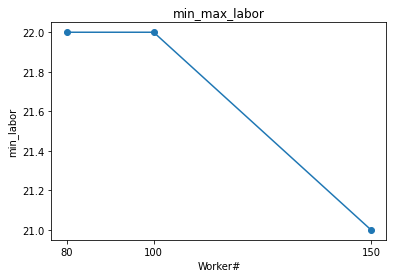

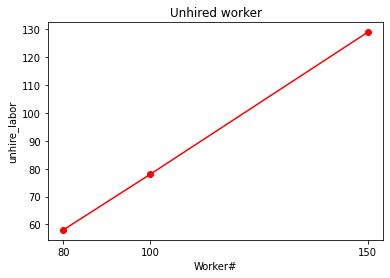

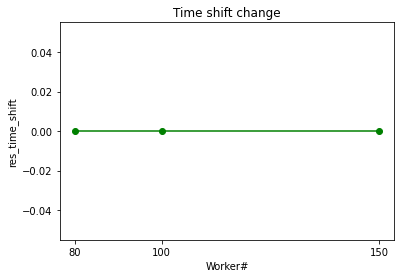

In [ ]:
#graph for model_2 (preference list=10) 
# for worker =20 ,　due to strictly constraint can't run
# for worker =40 ,　due to strictly constraint can't run
# for worker =80 ,　min labor =22 , unhire=58, the rest of time shift= =>Max hire # worker
# for worker =100,　min labor =22 , unhire=78,　the rest of time shift= 
# for worker =150,　min labor =21 , unhire=129,　the rest of time shift=
# for worker =200,　model too large can't run


pre10_Worker =[80,100,150]
pre10_min_labor =[22,22,21]
pre10_unhire =[58,78,129]
pre10_res_time =[0,0,0]
labels = [80,100,150]

#graph_1
plt.plot(pre10_Worker,pre10_min_labor,marker='o')
plt.xticks(pre10_Worker, labels)
plt.xlabel('Worker#')
plt.ylabel('min_labor')
plt.title("min_max_labor")
plt.show()


#graph_2
plt.plot(pre10_Worker,pre10_unhire,marker='o',color ='r')
plt.xticks(pre10_Worker, labels)
plt.xlabel('Worker#')
plt.ylabel('unhire_labor')
plt.title("Unhired worker")
plt.show()

#graph_3
plt.plot(pre10_Worker,pre10_res_time,marker='o',color ='g')
plt.xticks(pre10_Worker, labels)
plt.xlabel('Worker#')
plt.ylabel('res_time_shift')
plt.title("Time shift change")
plt.show()

Variable_Min labor# : 3.3777777777777778
STD_Min labor# : 1.837873166945363
Average_Min labor# : 34.4


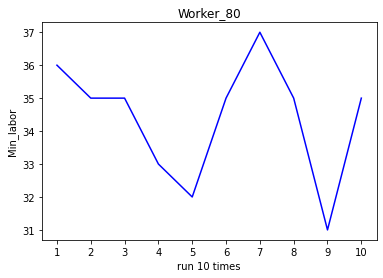

In [ ]:
#run 10times to caculate max value (Max hire labor is around 22 with worker =80)

number =[1,2,3,4,5,6,7,8,9,10]
min_labor_80 =[22,22,22,22,22,22,22,22,22,22]
min_labor_mean = statistics.mean(min_labor)

var= statistics.variance(min_labor)
std= statistics.stdev(min_labor)
print('Variable_Min labor# :',var)
print('STD_Min labor# :',std)
print('Average_Min labor# :',min_labor_mean)


labels = [1,2,3,4,5,6,7,8,9,10]
plt.xticks(number, labels)
plt.plot(number,min_labor,color='blue')
plt.xlabel('run 10 times')
plt.ylabel('Min_labor')
plt.title("Worker_80")
plt.show()

Comapre two model graph

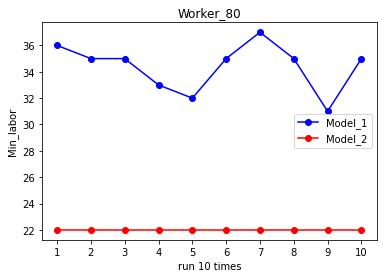

In [ ]:
# run 10 times result of model_1 v.s model_2
labels = [1,2,3,4,5,6,7,8,9,10]
plt.xticks(number, labels)
            
line1 = plt.plot(number,min_labor,color='blue',marker='o', label = 'Model_1') 
line2 = plt.plot(number_80,min_labor_80,color='red',marker='o',  label = 'Model_2')
plt.legend()
plt.xlabel('run 10 times')
plt.ylabel('Min_labor')
plt.title("Worker_80")
plt.legend()
plt.show()


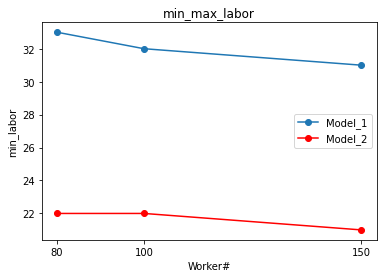

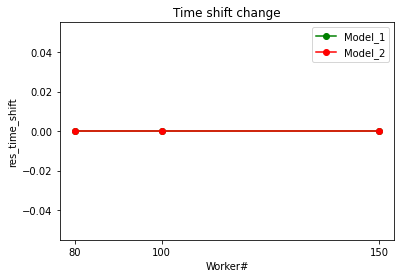

In [ ]:
pre10_Worker =[80,100,150]
pre10_min_labor =[33,32,31,]
pre10_res_time =[0,0,0]
pre10_res_time_2 =[0,0,0]
labels = [80,100,150]
pre10_min_labor_2 =[22,22,21]

#graph_1
line1=plt.plot(pre10_Worker,pre10_min_labor,marker='o', label = 'Model_1')
line2=plt.plot(pre10_Worker,pre10_min_labor_2,marker='o',color='r', label = 'Model_2')
plt.xticks(pre10_Worker, labels)
plt.xlabel('Worker#')
plt.ylabel('min_labor')
plt.title("min_max_labor")
plt.legend()
plt.show()


#graph_3
line1=plt.plot(pre10_Worker,pre10_res_time,marker='o',color ='g', label = 'Model_1')
line2=plt.plot(pre10_Worker,pre10_res_time_2,marker='o',color ='r', label = 'Model_2')
plt.xticks(pre10_Worker, labels)
plt.xlabel('Worker#')
plt.ylabel('res_time_shift')
plt.title("Time shift change")
plt.legend()
plt.show()